In [1]:
!git clone https://github.com/Trustworthy-ML-Lab/CLIP-dissect.git
%cd CLIP-dissect

Cloning into 'CLIP-dissect'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 104 (delta 12), reused 14 (delta 8), pack-reused 80 (from 1)
Receiving objects: 100% (104/104), 15.94 MiB | 30.98 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/kaggle/working/CLIP-dissect


In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-g3abrk6a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-g3abrk6a
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 

In [3]:
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar

--2025-07-12 22:48:42--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘resnet18_places365.pth.tar’

resnet18_places365. 100%[===================>]  43.40M  54.4MB/s    in 0.8s    

2025-07-12 22:48:43 (54.4 MB/s) - ‘resnet18_places365.pth.tar’ saved [45506139/45506139]



In [5]:
import torch
import torchvision.models as models

def load_resnet18_places365():
    model = models.resnet18(num_classes=365)
    checkpoint = torch.load("resnet18_places365.pth.tar", map_location="cpu")
    state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
    model.load_state_dict(state_dict)
    model.eval()
    return model

In [9]:
# Read and display the file content
with open("utils.py", "r") as f:
    code = f.read()
print(code[:10000])  # show first 1000 characters (change if needed)

import os
import math
import numpy as np
import torch
import clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import data_utils

PM_SUFFIX = {"max":"_max", "avg":""}

def get_activation(outputs, mode):
    '''
    mode: how to pool activations: one of avg, max
    for fc or ViT neurons does no pooling
    '''
    if mode=='avg':
        def hook(model, input, output):
            if len(output.shape)==4: #CNN layers
                outputs.append(output.mean(dim=[2,3]).detach())
            elif len(output.shape)==3: #ViT
                outputs.append(output[:, 0].clone())
            elif len(output.shape)==2: #FC layers
                outputs.append(output.detach())
    elif mode=='max':
        def hook(model, input, output):
            if len(output.shape)==4: #CNN layers
                outputs.append(output.amax(dim=[2,3]).detach())
            elif len(output.shape)==3: #ViT
                outputs.append(output[:, 0].clone())
            elif len(output.sha

In [10]:
!mkdir -p data
!mv resnet18_places365.pth.tar data/

In [12]:
%cd /kaggle/working/CLIP-dissect


/kaggle/working/CLIP-dissect


In [14]:
!bash dlbroden.sh

/kaggle/working/CLIP-dissect/data /kaggle/working/CLIP-dissect
--2025-07-12 23:02:51--  http://netdissect.csail.mit.edu/data/broden1_224.zip
Resolving netdissect.csail.mit.edu (netdissect.csail.mit.edu)... 128.52.131.63
Connecting to netdissect.csail.mit.edu (netdissect.csail.mit.edu)|128.52.131.63|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 937582103 (894M) [application/zip]
Saving to: ‘broden1_224.zip’

broden1_224.zip     100%[===================>] 894.15M  70.3MB/s    in 13s     

2025-07-12 23:03:05 (67.8 MB/s) - ‘broden1_224.zip’ saved [937582103/937582103]

/kaggle/working/CLIP-dissect/data/broden1_224 /kaggle/working/CLIP-dissect/data /kaggle/working/CLIP-dissect
/kaggle/working/CLIP-dissect/data /kaggle/working/CLIP-dissect


In [15]:
!python describe_neurons.py \
    --target_model resnet18_places \
    --target_layers layer2,layer3,layer4 \
    --d_probe broden \
    --concept_set data/20k.txt \
    --device cuda

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.64it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|████████████████████████████████████████| 128/128 [00:01<00:00, 125.71it/s]
torch.Size([128, 20000])
100%|████████████████████████████████████████| 256/256 [00:01<00:00, 159.08it/s]
torch.Size([256, 20000])
100%|████████████████████████████████████████| 512/512 [00:03<00:00, 161.84it/s]
torch.Size([512, 20000])


In [16]:
!python describe_neurons.py \
    --target_model resnet18 \
    --target_layers layer2,layer3,layer4 \
    --d_probe broden \
    --concept_set data/20k.txt \
    --device cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 182MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|████████████████████████████████████████| 128/128 [00:00<00:00, 142.30it/s]
torch.Size([128, 20000])
100%|████████████████████████████████████████| 256/256 [00:01<00:00, 148.56it/s]
torch.Size([256, 20000])
100%|████████████████████████████████████████| 512/512 [00:03<00:00, 162.97it/s]
torch.Size([512, 20000])


## Dataset Loading

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
import numpy as np
# -------------------------------
# Load both datasets
# -------------------------------


df_imagenet = pd.read_csv('/kaggle/input/imagenet/descriptions.csv')
df_imagenet['model'] = 'ImageNet'

df_places = pd.read_csv('/kaggle/input/places/descriptions.csv')
df_places['model'] = 'Places365'

## ImageNet Visualization

In [29]:
# Display basic info
print(f"Total rows: {len(df_imagenet)}")
print(f"Layers present: {df_imagenet['layer'].unique()}")
print(f"Number of units per layer:")
print(df_imagenet.groupby('layer')['unit'].nunique())

# Show sample data
df_imagenet.head()

Total rows: 896
Layers present: ['layer2' 'layer3' 'layer4']
Number of units per layer:
layer
layer2    128
layer3    256
layer4    512
Name: unit, dtype: int64


,layer,unit,description,similarity,model
0,layer2,0,red,0.262207,ImageNet
1,layer2,1,dotted,0.218140,ImageNet
2,layer2,2,tribal,0.156525,ImageNet
3,layer2,3,turquoise,0.221619,ImageNet
4,layer2,4,knots,0.123932,ImageNet


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


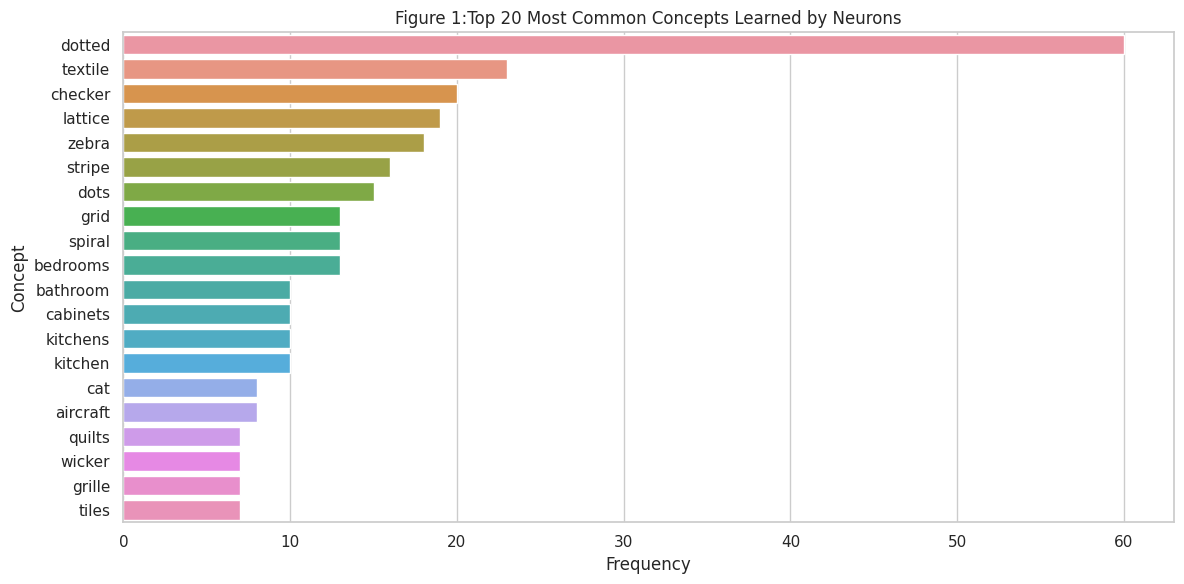

In [30]:
# Analyze most common concepts
all_descriptions = df_imagenet['description'].str.lower().tolist()
description_counts = Counter(all_descriptions)
top_concepts = description_counts.most_common(20)

# Plot top concepts
plt.figure(figsize=(12, 6))
sns.barplot(x=[count for concept, count in top_concepts], 
            y=[concept for concept, count in top_concepts])
plt.title('Figure 1:Top 20 Most Common Concepts Learned by Neurons')
plt.xlabel('Frequency')
plt.ylabel('Concept')
plt.tight_layout()
plt.show()

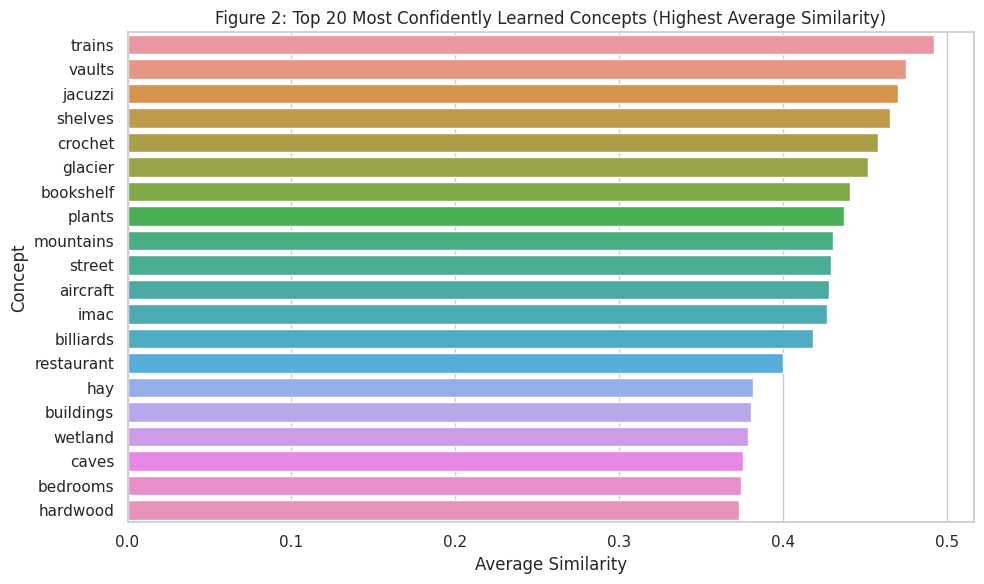

In [31]:
top_confident_concepts = df_imagenet.groupby('description')['similarity'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_confident_concepts.index, x=top_confident_concepts.values)
plt.title('Figure 2: Top 20 Most Confidently Learned Concepts (Highest Average Similarity)')
plt.xlabel('Average Similarity')
plt.ylabel('Concept')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


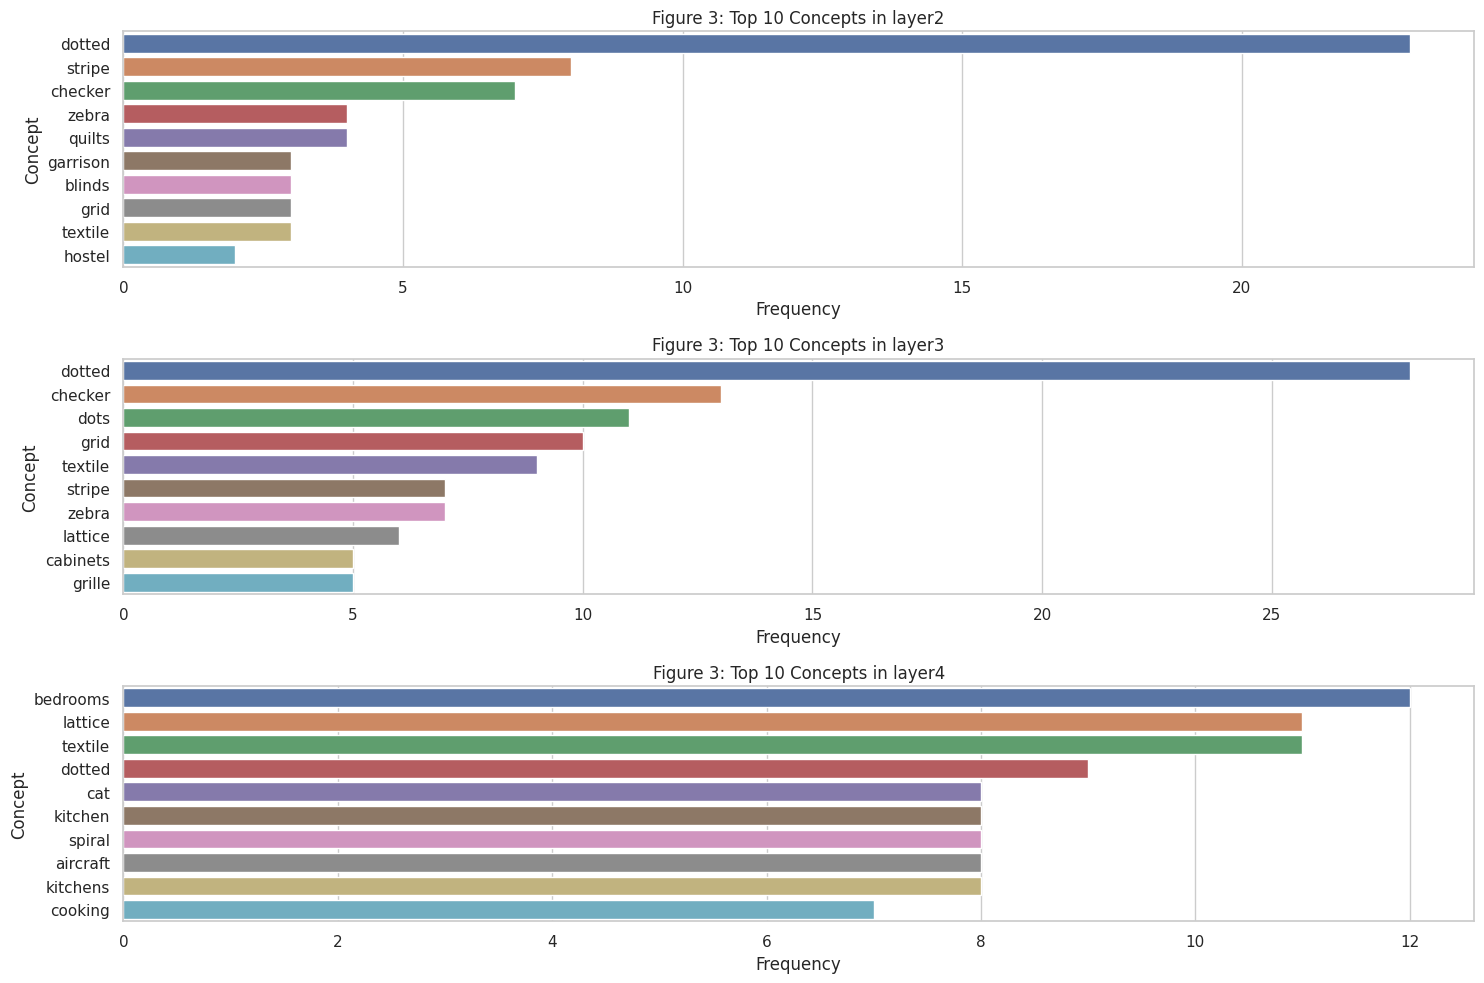

In [32]:
# Get top concepts per layer
layer_groups = df_imagenet.groupby('layer')

plt.figure(figsize=(15, 10))
for i, (layer, group) in enumerate(layer_groups, 1):
    layer_descriptions = group['description'].str.lower().tolist()
    layer_counts = Counter(layer_descriptions).most_common(10)
    
    plt.subplot(3, 1, i)
    sns.barplot(x=[count for concept, count in layer_counts], 
                y=[concept for concept, count in layer_counts])
    plt.title(f'Figure 3: Top 10 Concepts in {layer}')
    plt.xlabel('Frequency')
    plt.ylabel('Concept')

plt.tight_layout()
plt.show()

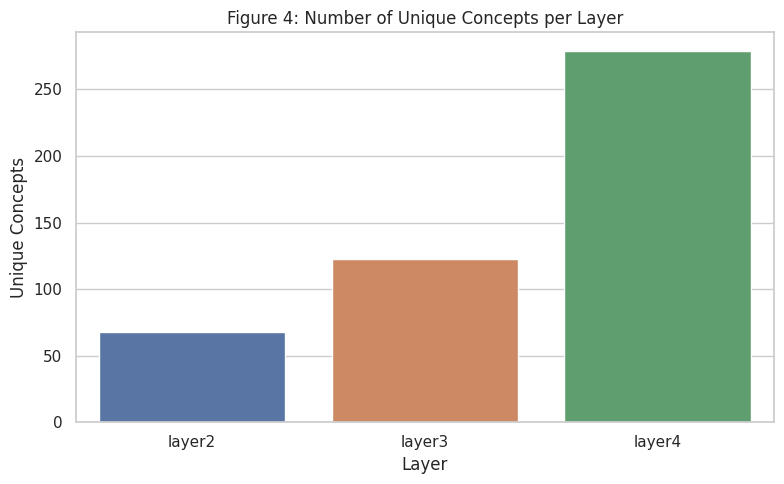

In [33]:
# -------------------------------
# 3. Unique concepts per layer
# -------------------------------
unique_per_layer = df_imagenet.groupby('layer')['description'].nunique()
plt.figure(figsize=(8, 5))
sns.barplot(x=unique_per_layer.index, y=unique_per_layer.values)
plt.title('Figure 4: Number of Unique Concepts per Layer')
plt.xlabel('Layer')
plt.ylabel('Unique Concepts')
plt.tight_layout()
plt.show()



In [34]:
unique_concepts = df_imagenet['description'].nunique()
print(f"Total unique concepts learned: {unique_concepts}")

# Count by layer
for layer, group in df_imagenet.groupby('layer'):
    print(f"Unique concepts in {layer}: {group['description'].nunique()}")

Total unique concepts learned: 374
Unique concepts in layer2: 68
Unique concepts in layer3: 123
Unique concepts in layer4: 279


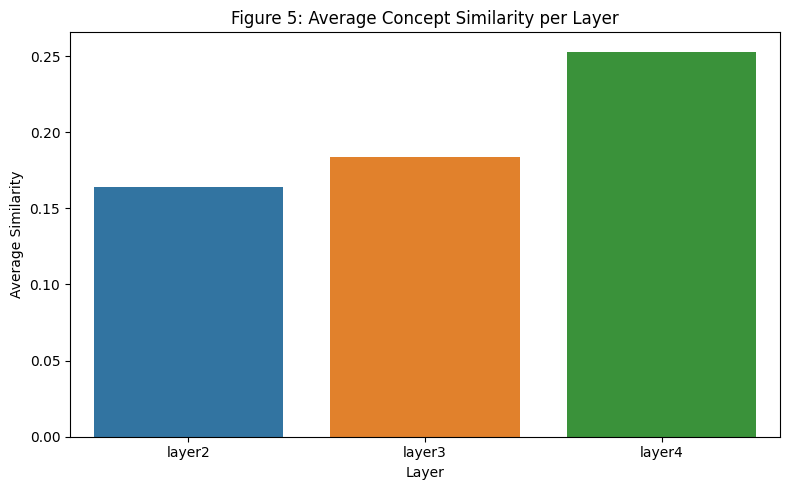

In [7]:
# -------------------------------
# 4. Average similarity per layer
# -------------------------------
avg_sim_layer = df_imagenet.groupby('layer')['similarity'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_sim_layer.index, y=avg_sim_layer.values)
plt.title('Figure 5: Average Concept Similarity per Layer')
plt.xlabel('Layer')
plt.ylabel('Average Similarity')
plt.tight_layout()
plt.show()


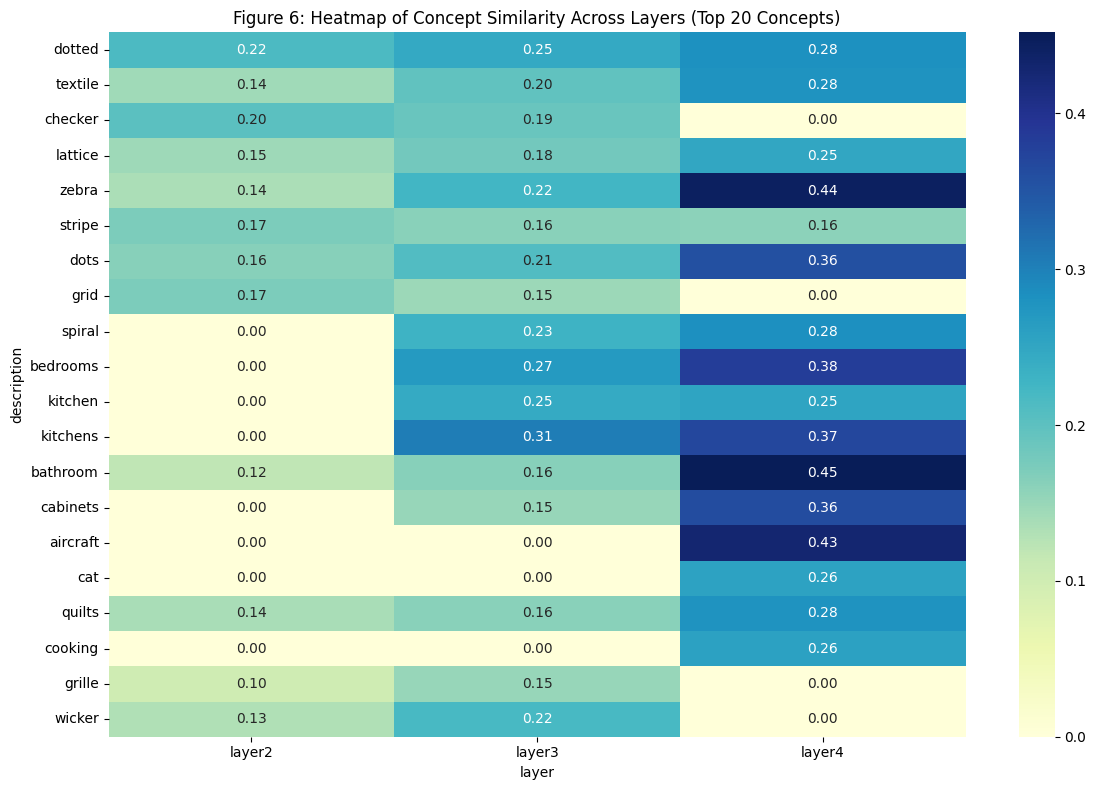

In [8]:
# -------------------------------
# Heatmap: concept frequency vs layer
# -------------------------------
concept_layer_matrix = df_imagenet.pivot_table(index='description', columns='layer', values='similarity', aggfunc='mean').fillna(0)
top_heatmap = concept_layer_matrix.loc[df_imagenet['description'].value_counts().head(20).index]

plt.figure(figsize=(12, 8))
sns.heatmap(top_heatmap, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Figure 6: Heatmap of Concept Similarity Across Layers (Top 20 Concepts)')
plt.tight_layout()
plt.show()

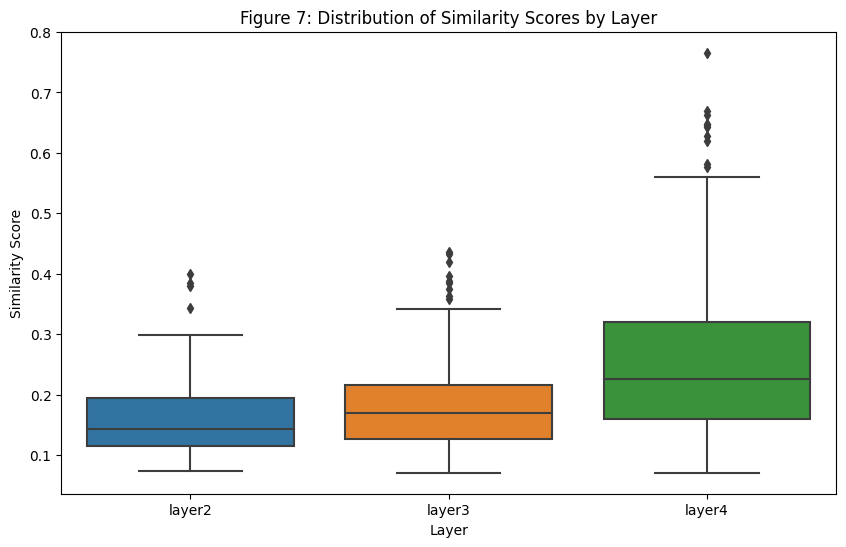

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


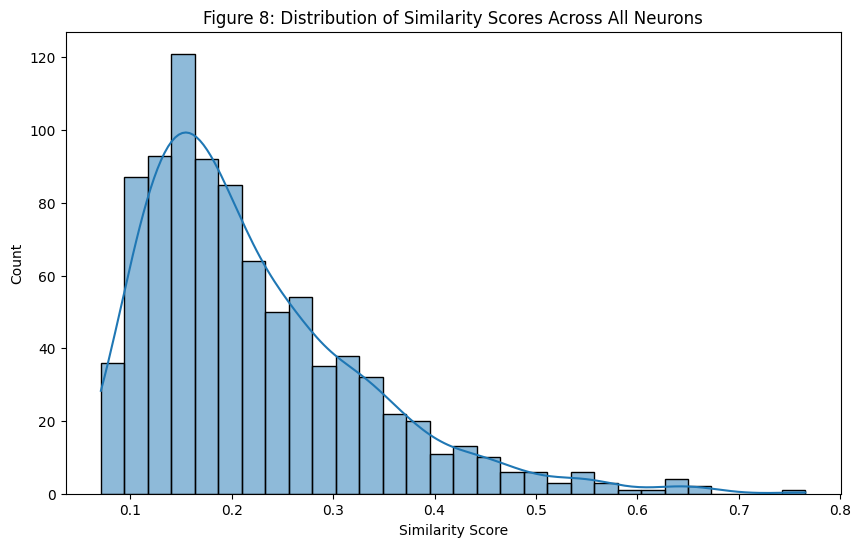

In [9]:
# Plot similarity score distributions by layer
plt.figure(figsize=(10, 6))
sns.boxplot(x='layer', y='similarity', data=df_imagenet)
plt.title('Figure 7: Distribution of Similarity Scores by Layer')
plt.ylabel('Similarity Score')
plt.xlabel('Layer')
plt.show()

# Plot histogram of similarity scores
plt.figure(figsize=(10, 6))
sns.histplot(df_imagenet['similarity'], bins=30, kde=True)
plt.title('Figure 8: Distribution of Similarity Scores Across All Neurons')
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.show()

## Places365 Visualization

In [12]:
# Display basic info
print(f"Total rows: {len(df_places)}")
print(f"Layers present: {df_places['layer'].unique()}")
print(f"Number of units per layer:")
print(df_places.groupby('layer')['unit'].nunique())

# Show sample data
df_places.head()

Total rows: 896
Layers present: ['layer2' 'layer3' 'layer4']
Number of units per layer:
layer
layer2    128
layer3    256
layer4    512
Name: unit, dtype: int64


,layer,unit,description,similarity,model
0,layer2,0,hoodia,0.241425,Places365
1,layer2,1,lattice,0.191895,Places365
2,layer2,2,dotted,0.173492,Places365
3,layer2,3,stripe,0.128876,Places365
4,layer2,4,stripes,0.397461,Places365


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


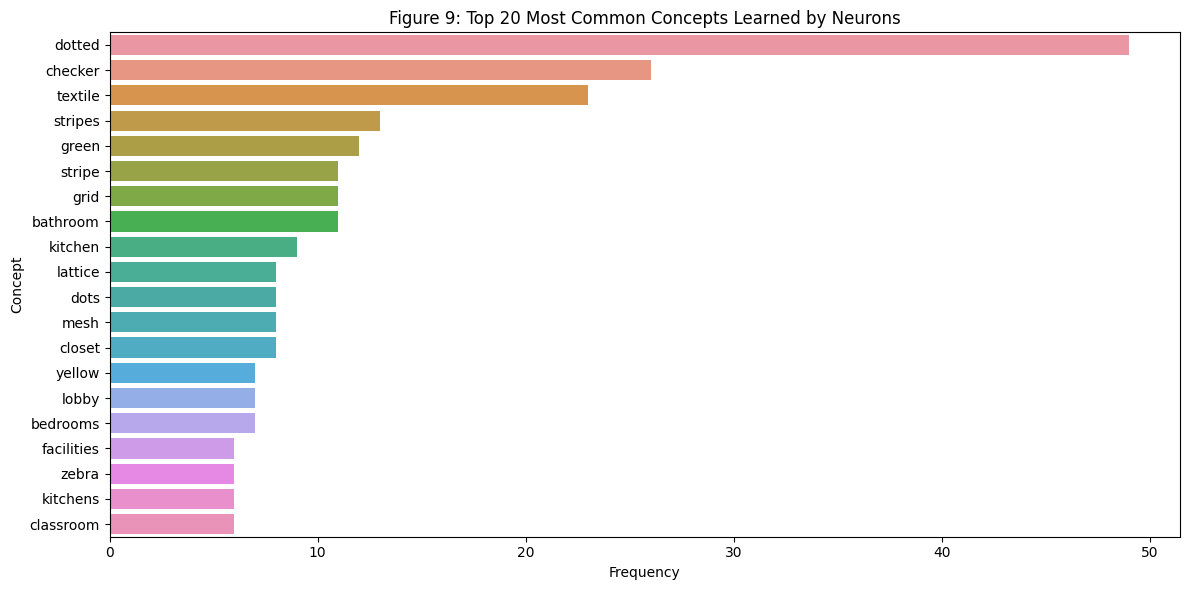

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
from collections import Counter
import numpy as np
# Analyze most common concepts
all_descriptions = df_places['description'].str.lower().tolist()
description_counts = Counter(all_descriptions)
top_concepts = description_counts.most_common(20)

# Plot top concepts
plt.figure(figsize=(12, 6))
sns.barplot(x=[count for concept, count in top_concepts], 
            y=[concept for concept, count in top_concepts])
plt.title('Figure 9: Top 20 Most Common Concepts Learned by Neurons')
plt.xlabel('Frequency')
plt.ylabel('Concept')
plt.tight_layout()
plt.show()

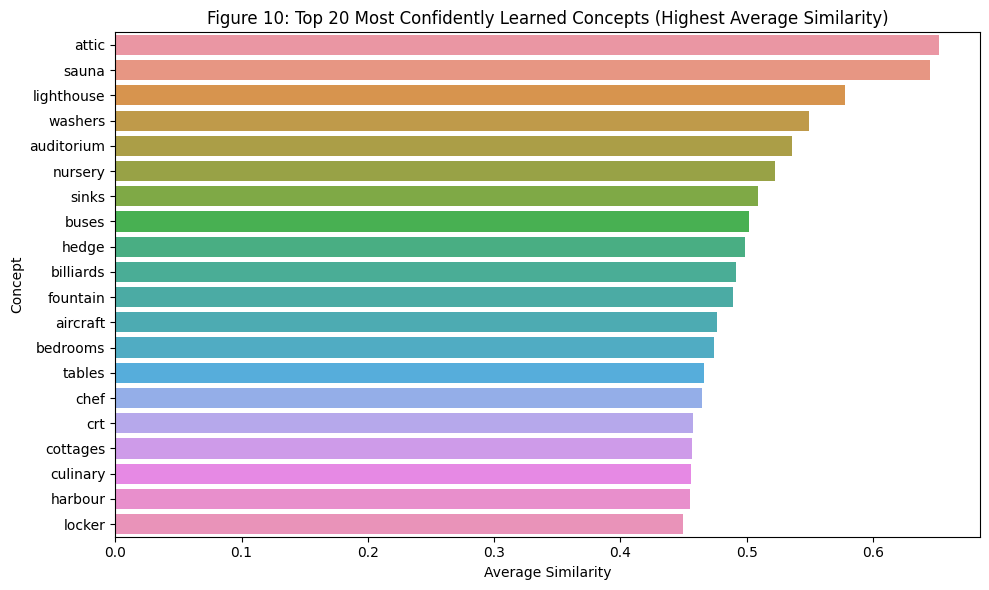

In [11]:
top_confident_concepts = df_places.groupby('description')['similarity'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_confident_concepts.index, x=top_confident_concepts.values)
plt.title('Figure 10: Top 20 Most Confidently Learned Concepts (Highest Average Similarity)')
plt.xlabel('Average Similarity')
plt.ylabel('Concept')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


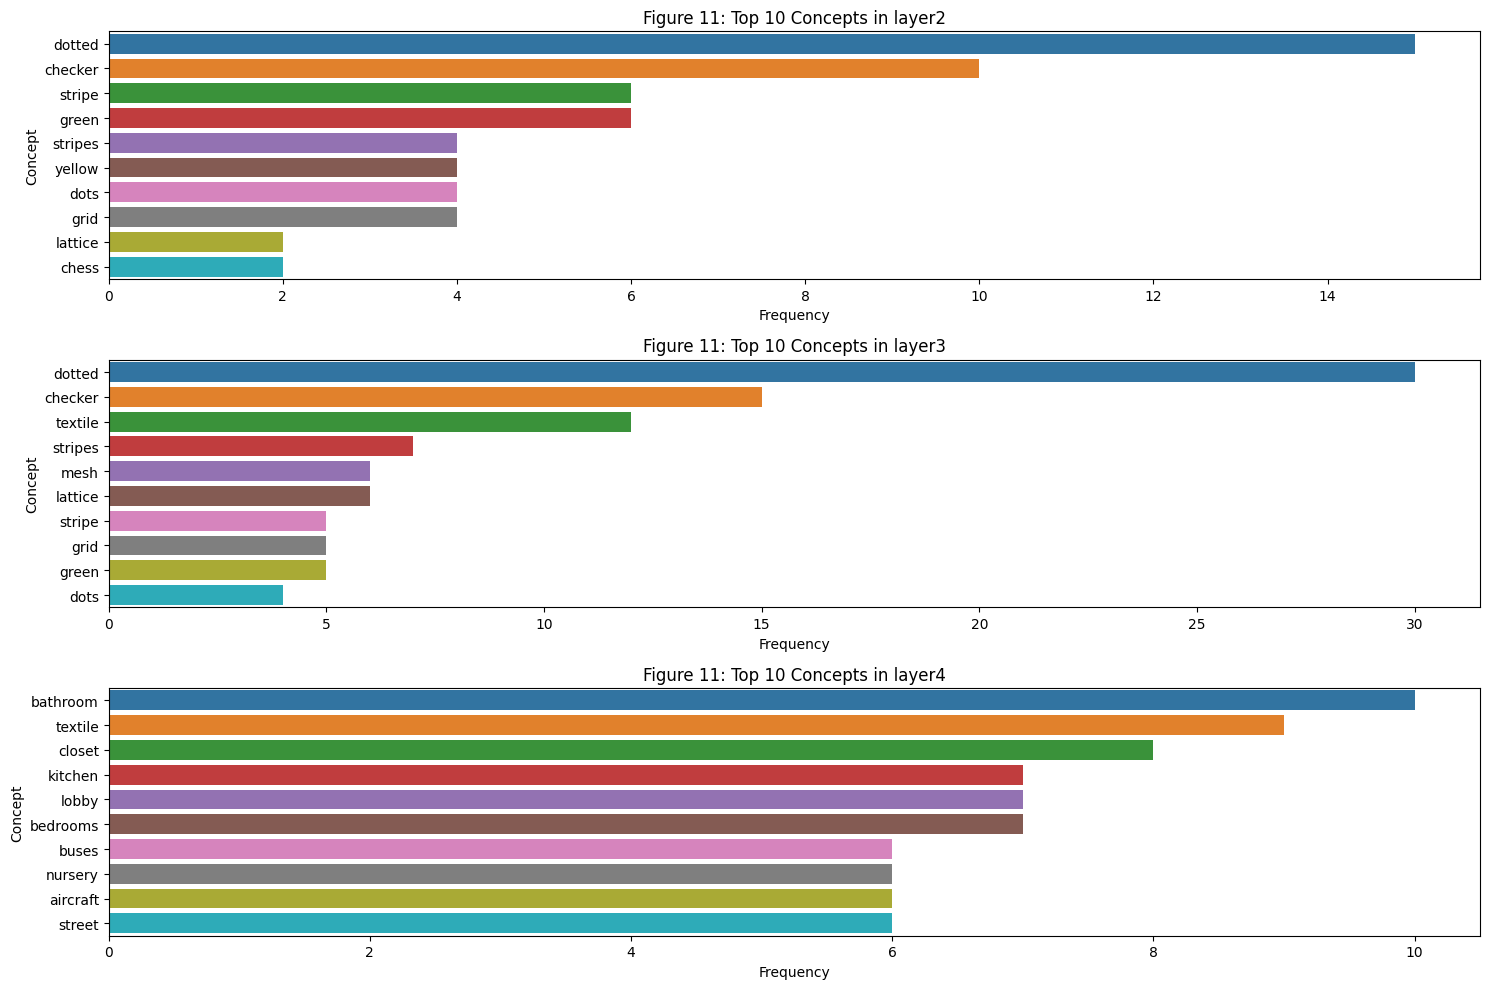

In [12]:
# Get top concepts per layer
layer_groups = df_places.groupby('layer')

plt.figure(figsize=(15, 10))
for i, (layer, group) in enumerate(layer_groups, 1):
    layer_descriptions = group['description'].str.lower().tolist()
    layer_counts = Counter(layer_descriptions).most_common(10)
    
    plt.subplot(3, 1, i)
    sns.barplot(x=[count for concept, count in layer_counts], 
                y=[concept for concept, count in layer_counts])
    plt.title(f'Figure 11: Top 10 Concepts in {layer}')
    plt.xlabel('Frequency')
    plt.ylabel('Concept')

plt.tight_layout()
plt.show()

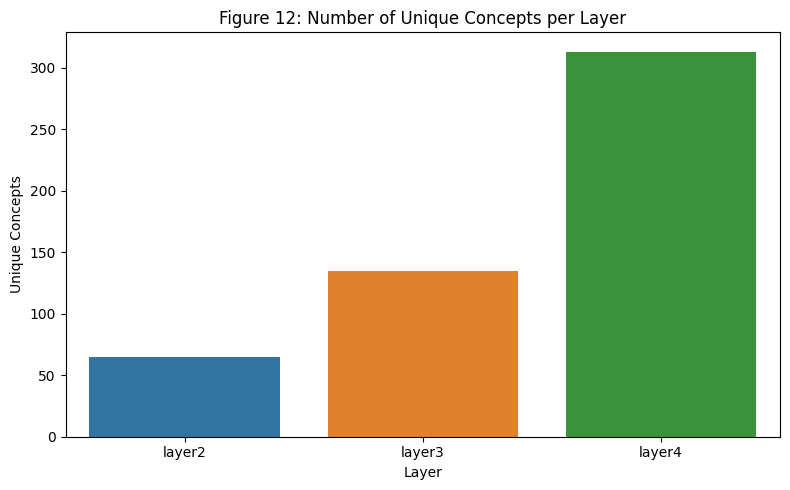

In [13]:
# -------------------------------
# 3. Unique concepts per layer
# -------------------------------
unique_per_layer = df_places.groupby('layer')['description'].nunique()
plt.figure(figsize=(8, 5))
sns.barplot(x=unique_per_layer.index, y=unique_per_layer.values)
plt.title('Figure 12: Number of Unique Concepts per Layer')
plt.xlabel('Layer')
plt.ylabel('Unique Concepts')
plt.tight_layout()
plt.show()



In [22]:
unique_concepts = df_places['description'].nunique()
print(f"Total unique concepts learned: {unique_concepts}")

# Count by layer
for layer, group in df_places.groupby('layer'):
    print(f"Unique concepts in {layer}: {group['description'].nunique()}")

Total unique concepts learned: 427
Unique concepts in layer2: 65
Unique concepts in layer3: 135
Unique concepts in layer4: 313


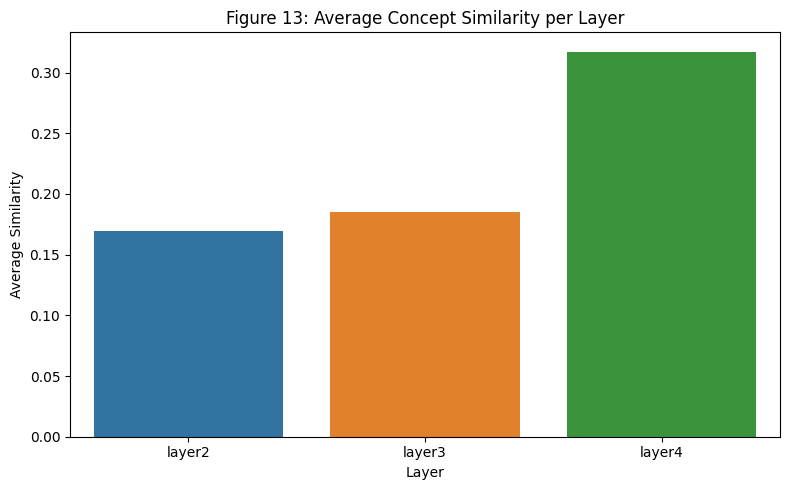

In [14]:
# -------------------------------
# 4. Average similarity per layer
# -------------------------------
avg_sim_layer = df_places.groupby('layer')['similarity'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_sim_layer.index, y=avg_sim_layer.values)
plt.title('Figure 13: Average Concept Similarity per Layer')
plt.xlabel('Layer')
plt.ylabel('Average Similarity')
plt.tight_layout()
plt.show()


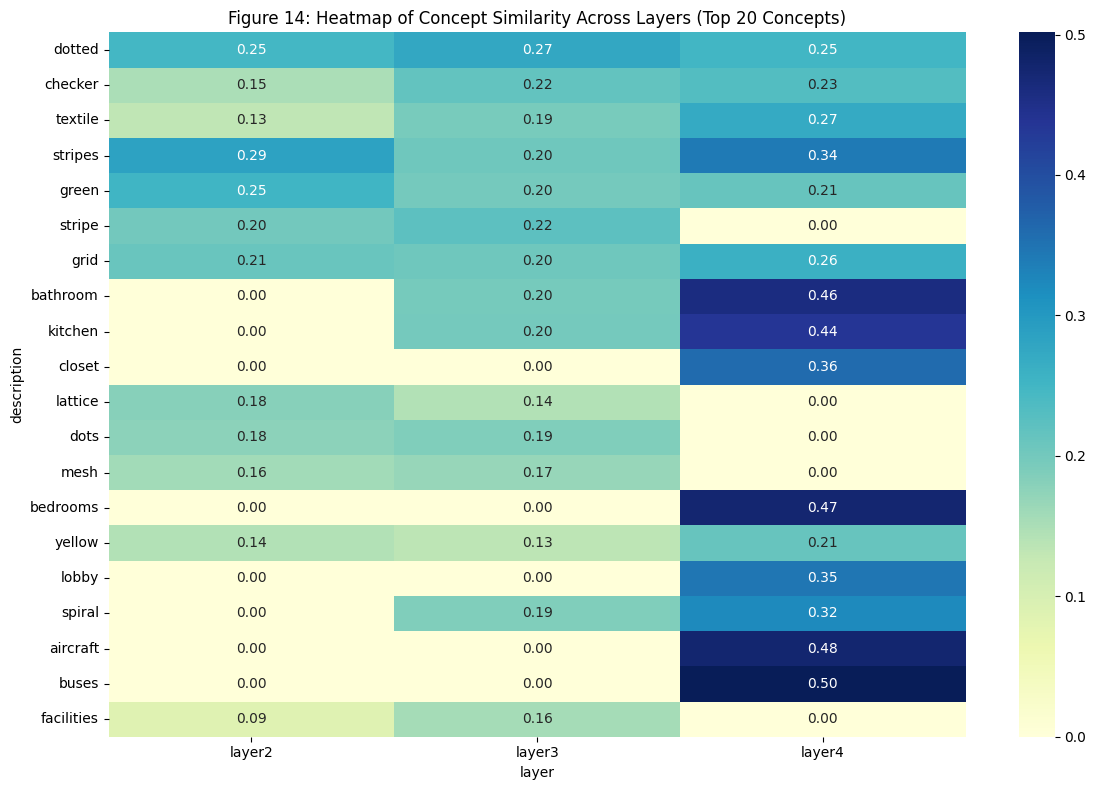

In [15]:
# -------------------------------
# Heatmap: concept frequency vs layer
# -------------------------------
concept_layer_matrix = df_places.pivot_table(index='description', columns='layer', values='similarity', aggfunc='mean').fillna(0)
top_heatmap = concept_layer_matrix.loc[df_places['description'].value_counts().head(20).index]

plt.figure(figsize=(12, 8))
sns.heatmap(top_heatmap, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Figure 14: Heatmap of Concept Similarity Across Layers (Top 20 Concepts)')
plt.tight_layout()
plt.show()

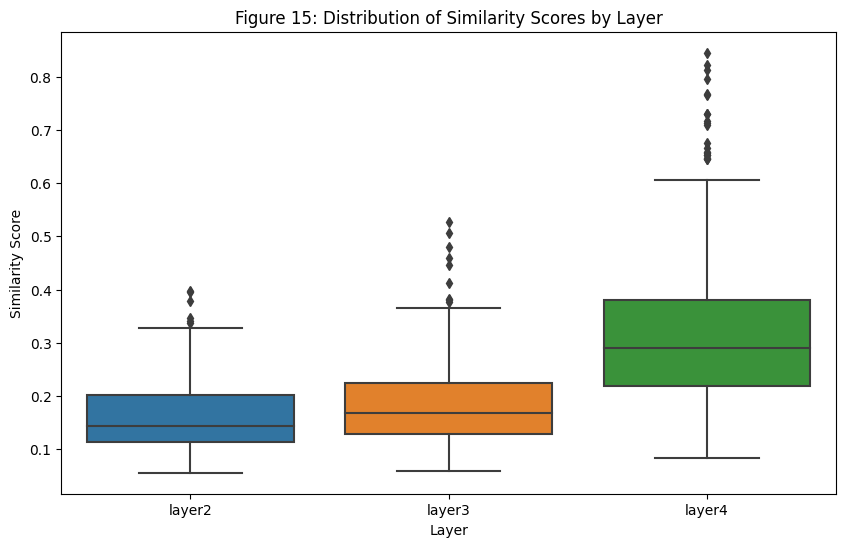

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


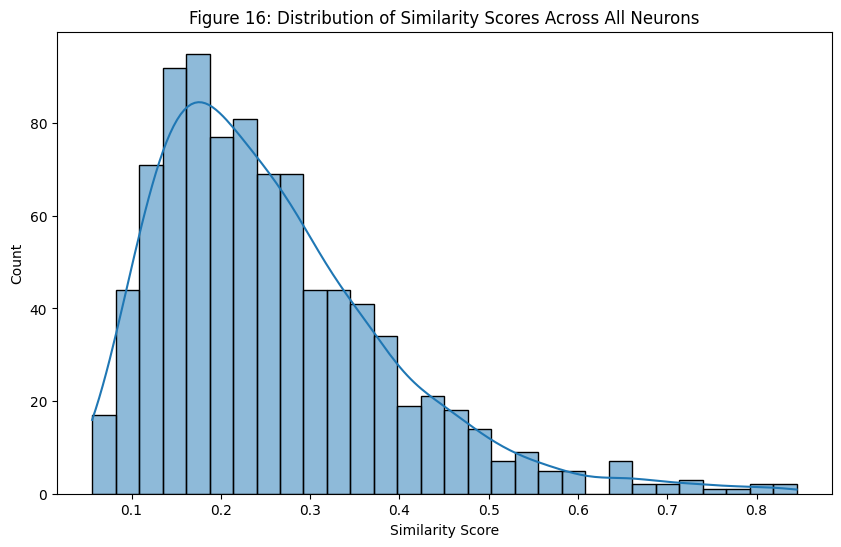

In [17]:
# Plot similarity score distributions by layer
plt.figure(figsize=(10, 6))
sns.boxplot(x='layer', y='similarity', data=df_places)
plt.title('Figure 15: Distribution of Similarity Scores by Layer')
plt.ylabel('Similarity Score')
plt.xlabel('Layer')
plt.show()

# Plot histogram of similarity scores
plt.figure(figsize=(10, 6))
sns.histplot(df_places['similarity'], bins=30, kde=True)
plt.title('Figure 16: Distribution of Similarity Scores Across All Neurons')
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.show()

## COMPARISON 

In [22]:

# Combine them
df_combined = pd.concat([df_imagenet, df_places], ignore_index=True)
sns.set(style="whitegrid")

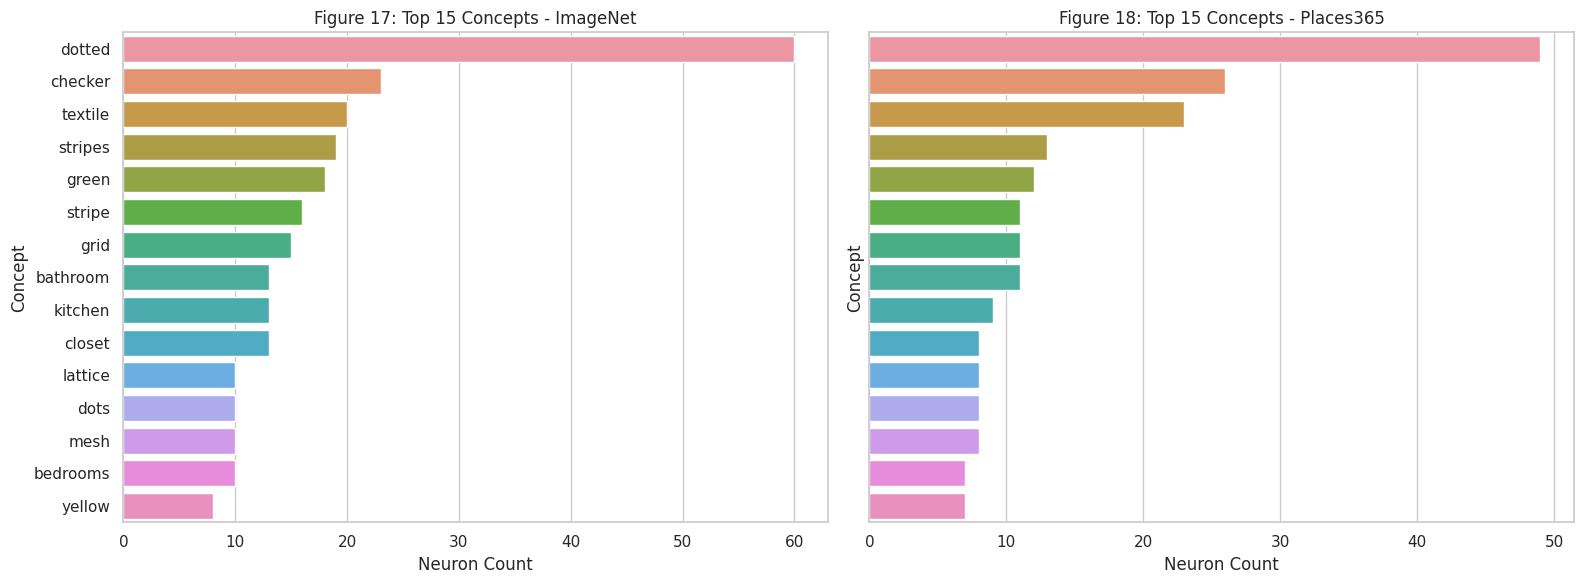

In [23]:
# -------------------------------
#Top 15 Concepts Per Model
# -------------------------------

top_imagenet = df_imagenet['description'].value_counts().head(15)
top_places = df_places['description'].value_counts().head(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.barplot(x=top_imagenet.values, y=top_imagenet.index, ax=axes[0])
axes[0].set_title('Figure 17: Top 15 Concepts - ImageNet')
axes[0].set_xlabel('Neuron Count')
axes[0].set_ylabel('Concept')

sns.barplot(x=top_places.values, y=top_places.index, ax=axes[1])
axes[1].set_title('Figure 18: Top 15 Concepts - Places365')
axes[1].set_xlabel('Neuron Count')
axes[1].set_ylabel('Concept')
plt.tight_layout()
plt.show()

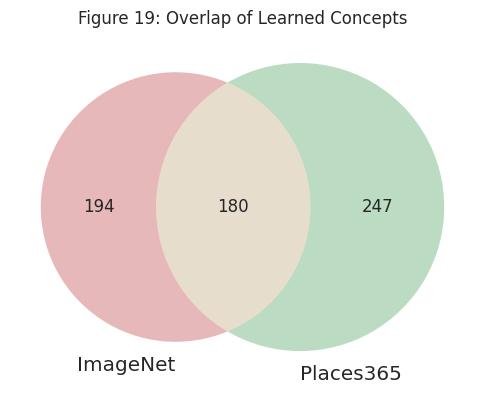

In [24]:
# -------------------------------
# Venn Diagram of Concept Overlap
# -------------------------------

concepts_imagenet = set(df_imagenet['description'])
concepts_places = set(df_places['description'])

plt.figure(figsize=(6, 6))
venn2([concepts_imagenet, concepts_places], set_labels=('ImageNet', 'Places365'))
plt.title('Figure 19: Overlap of Learned Concepts')
plt.show()

In [25]:
# -------------------------------
# Unique Concepts Per Layer
# -------------------------------

unique_concepts_by_layer = df_combined.groupby(['model', 'layer'])['description'].nunique().unstack()
print("Unique concepts per layer:\n", unique_concepts_by_layer)

Unique concepts per layer:
 layer      layer2  layer3  layer4
model                            
ImageNet       68     123     279
Places365      65     135     313


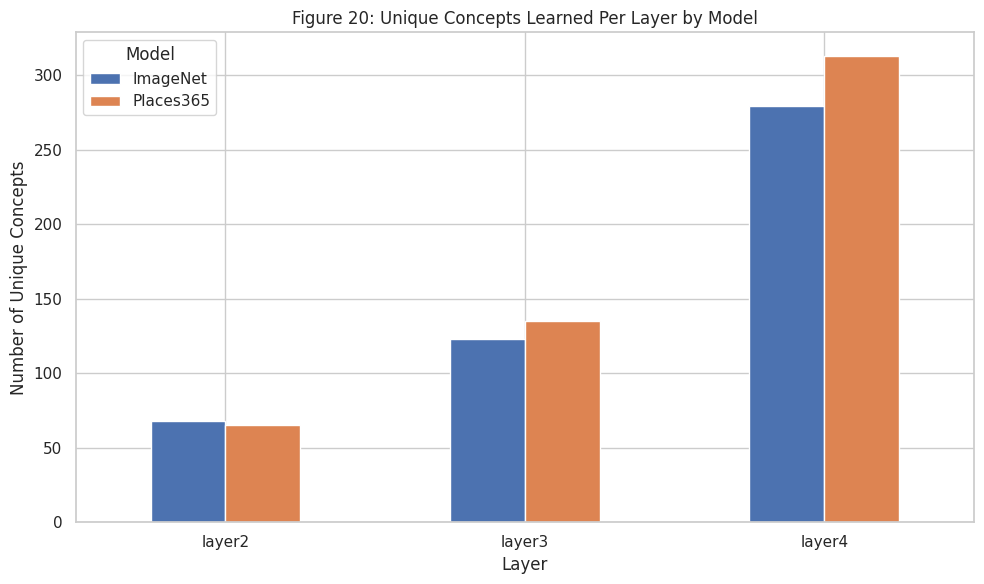

In [38]:
# Get unique concept counts
unique_concepts_by_layer = df_combined.groupby(['model', 'layer'])['description'].nunique().unstack()

unique_concepts_by_layer.T.plot(kind='bar', figsize=(10, 6))
plt.title('Figure 20: Unique Concepts Learned Per Layer by Model')  # Replace X with actual figure number
plt.xlabel('Layer')
plt.ylabel('Number of Unique Concepts')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


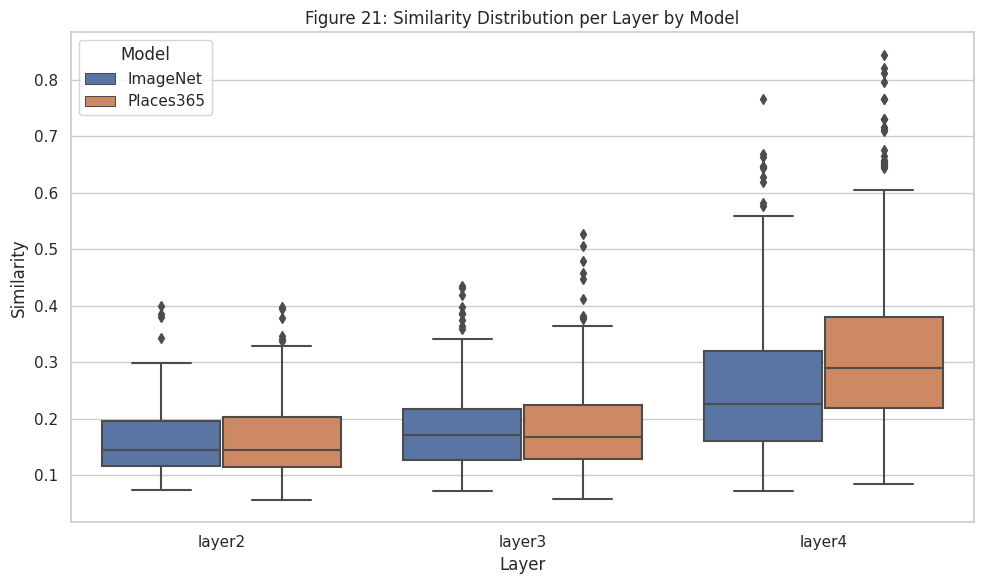

In [39]:
# -------------------------------
# Similarity Score Distribution
# -------------------------------

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x='layer', y='similarity', hue='model')
plt.title('Figure 21: Similarity Distribution per Layer by Model')
plt.ylabel('Similarity')
plt.xlabel('Layer')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [27]:
# -------------------------------
# Jaccard Similarity of Concept Sets
# -------------------------------

jaccard_similarity = len(concepts_imagenet & concepts_places) / len(concepts_imagenet | concepts_places)
print(f"Jaccard Similarity between concept sets: {jaccard_similarity:.2%}")


Jaccard Similarity between concept sets: 28.99%
